In [3]:
import tensorflow as tf
import tensorflow_datasets as tfds

In [5]:
data_ratings = tfds.load("movielens/100k-ratings", split='train', shuffle_files=False)

Dl Completed...: 0 url [00:00, ? url/s]
Dl Completed...: 100%|██████████| 1/1 [00:00<00:00, 90.92 url/s] 
Extraction completed...: 0 file [00:00, ? file/s]
Dl Completed...: 100%|██████████| 1/1 [00:00<00:00, 52.63 url/s]


Dataset movielens downloaded and prepared to C:\Users\blade\tensorflow_datasets\movielens\100k-ratings\0.1.1. Subsequent calls will reuse this data.


In [6]:
data_movies = tfds.load("movielens/100k-movies", split='train', shuffle_files=False)

Dl Completed...: 0 url [00:00, ? url/s]
Dl Completed...: 100%|██████████| 1/1 [00:00<00:00, 71.42 url/s]
Extraction completed...: 0 file [00:00, ? file/s]
Dl Completed...: 100%|██████████| 1/1 [00:00<00:00, 47.62 url/s]
                                                                        

Dataset movielens downloaded and prepared to C:\Users\blade\tensorflow_datasets\movielens\100k-movies\0.1.1. Subsequent calls will reuse this data.


In [7]:
import pandas as pd

In [8]:
df_ratings = tfds.as_dataframe(data_ratings)

In [10]:
df_ratings.head()

,bucketized_user_age,movie_genres,movie_id,movie_title,raw_user_age,timestamp,user_gender,user_id,user_occupation_label,user_occupation_text,user_rating,user_zip_code
0,45.0,[7],b'357',"b""One Flew Over the Cuckoo's Nest (1975)""",46.0,879024327,True,b'138',4,b'doctor',4.0,b'53211'
1,25.0,"[4, 14]",b'709',b'Strictly Ballroom (1992)',32.0,875654590,True,b'92',5,b'entertainment',2.0,b'80525'
2,18.0,[4],b'412',"b'Very Brady Sequel, A (1996)'",24.0,882075110,True,b'301',17,b'student',4.0,b'55439'
3,50.0,"[5, 7]",b'56',b'Pulp Fiction (1994)',50.0,883326919,True,b'60',4,b'healthcare',4.0,b'06472'
4,50.0,"[10, 16]",b'895',b'Scream 2 (1997)',55.0,891409199,True,b'197',18,b'technician',3.0,b'75094'


In [11]:
df_movies = tfds.as_dataframe(data_movies)

In [12]:
df_movies.head()

,movie_genres,movie_id,movie_title
0,[4],b'1681',b'You So Crazy (1994)'
1,"[4, 7]",b'1457',b'Love Is All There Is (1996)'
2,"[1, 3]",b'500',b'Fly Away Home (1996)'
3,[0],b'838',b'In the Line of Duty 2 (1987)'
4,[7],b'1648',"b'Niagara, Niagara (1997)'"


In [15]:
df_movies.to_csv("dataset/movielens/movielens_100k-movies.csv", index=True)

In [18]:
df_ratings.to_csv("dataset/movielens/movielens_100k-ratings.csv", index=True)

In [62]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [21]:
df_movies.shape

(1682, 3)

In [50]:
movie_ids_byte_int = torch.from_numpy(np.array(df_movies["movie_id"], dtype=int))
print(movie_ids_byte_int[0])
print(len(movie_ids_byte_int.unique()))


tensor(1681, dtype=torch.int32)
1682


In [54]:
movies_pairs = torch.stack((movie_ids_byte_int, torch.arange(df_movies.shape[0])), dim=1)
print(movies_pairs[0])
print(movies_pairs[-1])

tensor([1681,    0])
tensor([ 593, 1681])


In [53]:
user_ids_byte_int = torch.from_numpy(np.array(df_ratings["user_id"], dtype=int))
print(user_ids_byte_int[0])
print(torch.max(user_ids_byte_int))
print(len(user_ids_byte_int.unique()))

tensor(138, dtype=torch.int32)
tensor(943, dtype=torch.int32)
943


In [57]:
users_tensor = torch.add(torch.from_numpy(np.array(df_ratings["user_id"], dtype=int)), df_movies.shape[0])
print(users_tensor.shape)
print(torch.min(users_tensor))

torch.Size([100000])
tensor(1683, dtype=torch.int32)


In [59]:
movies_tensor = torch.from_numpy(np.array(df_ratings["movie_id"], dtype=int))
print(movies_tensor.shape)
print(torch.max(movies_tensor))

torch.Size([100000])
tensor(1682, dtype=torch.int32)


In [61]:
users_outdegrees = users_tensor.bincount()
movies_indegrees = movies_tensor.bincount()

users_outdegree_max = torch.max(users_outdegrees)
users_outdegree_argmax = torch.argmax(users_outdegrees)
movies_indegree_max = torch.max(movies_indegrees)
movies_indegree_argmax = torch.argmax(movies_indegrees)
print(f"Outdegree Max: {users_outdegree_max}")
print(f"Outdegree ArgMax: {users_outdegree_argmax}")
print(f"Indegree Max: {movies_indegree_max}")
print(f"Indegree ArgMax: {movies_indegree_argmax}")

users_outdegree_mean = torch.mean(users_outdegrees.to(float))
movies_indegree_mean = torch.mean(movies_indegrees.to(float))
print(f"Outdegree Mean: {users_outdegree_mean}")
print(f"Indegree_Mean: {movies_indegree_mean}")

Outdegree Max: 737
Outdegree ArgMax: 2087
Indegree Max: 583
Indegree ArgMax: 50
Outdegree Mean: 38.08073115003808
Indegree_Mean: 59.41770647653001


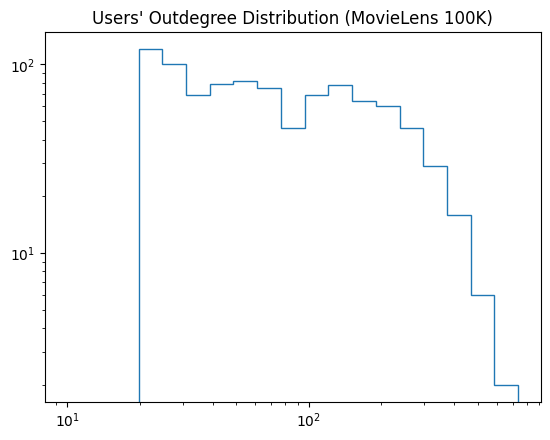

In [88]:
counts, bins = np.histogram(users_outdegrees, bins=np.logspace(np.log10(10), np.log10(users_outdegree_max), 20))
plt.stairs(counts, bins)
plt.xscale("log")
plt.yscale("log")
plt.title("Users' Outdegree Distribution (MovieLens 100K)")
plt.show()

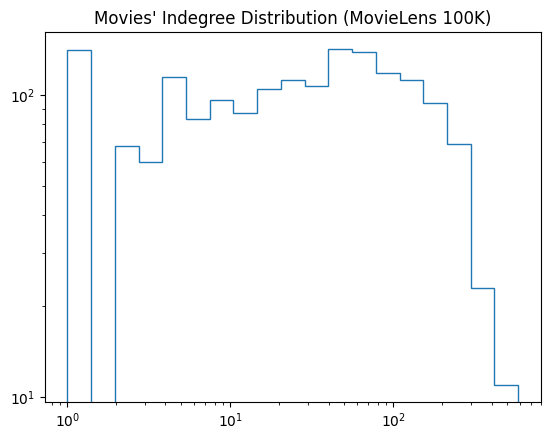

In [87]:
counts, bins = np.histogram(movies_indegrees, bins=np.logspace(np.log10(1), np.log10(movies_indegree_max), 20))
plt.stairs(counts, bins)
plt.xscale("log")
plt.yscale("log")
plt.title("Movies' Indegree Distribution (MovieLens 100K)")
plt.show()

In [95]:
edge_list = torch.stack((torch.cat((users_tensor, movies_tensor)), torch.cat((movies_tensor, users_tensor))), dim=1)

In [99]:
print(edge_list[0])

tensor([1820,  357], dtype=torch.int32)


In [96]:
import networkx as nx

In [97]:
graph_nx = nx.from_edgelist(edge_list)

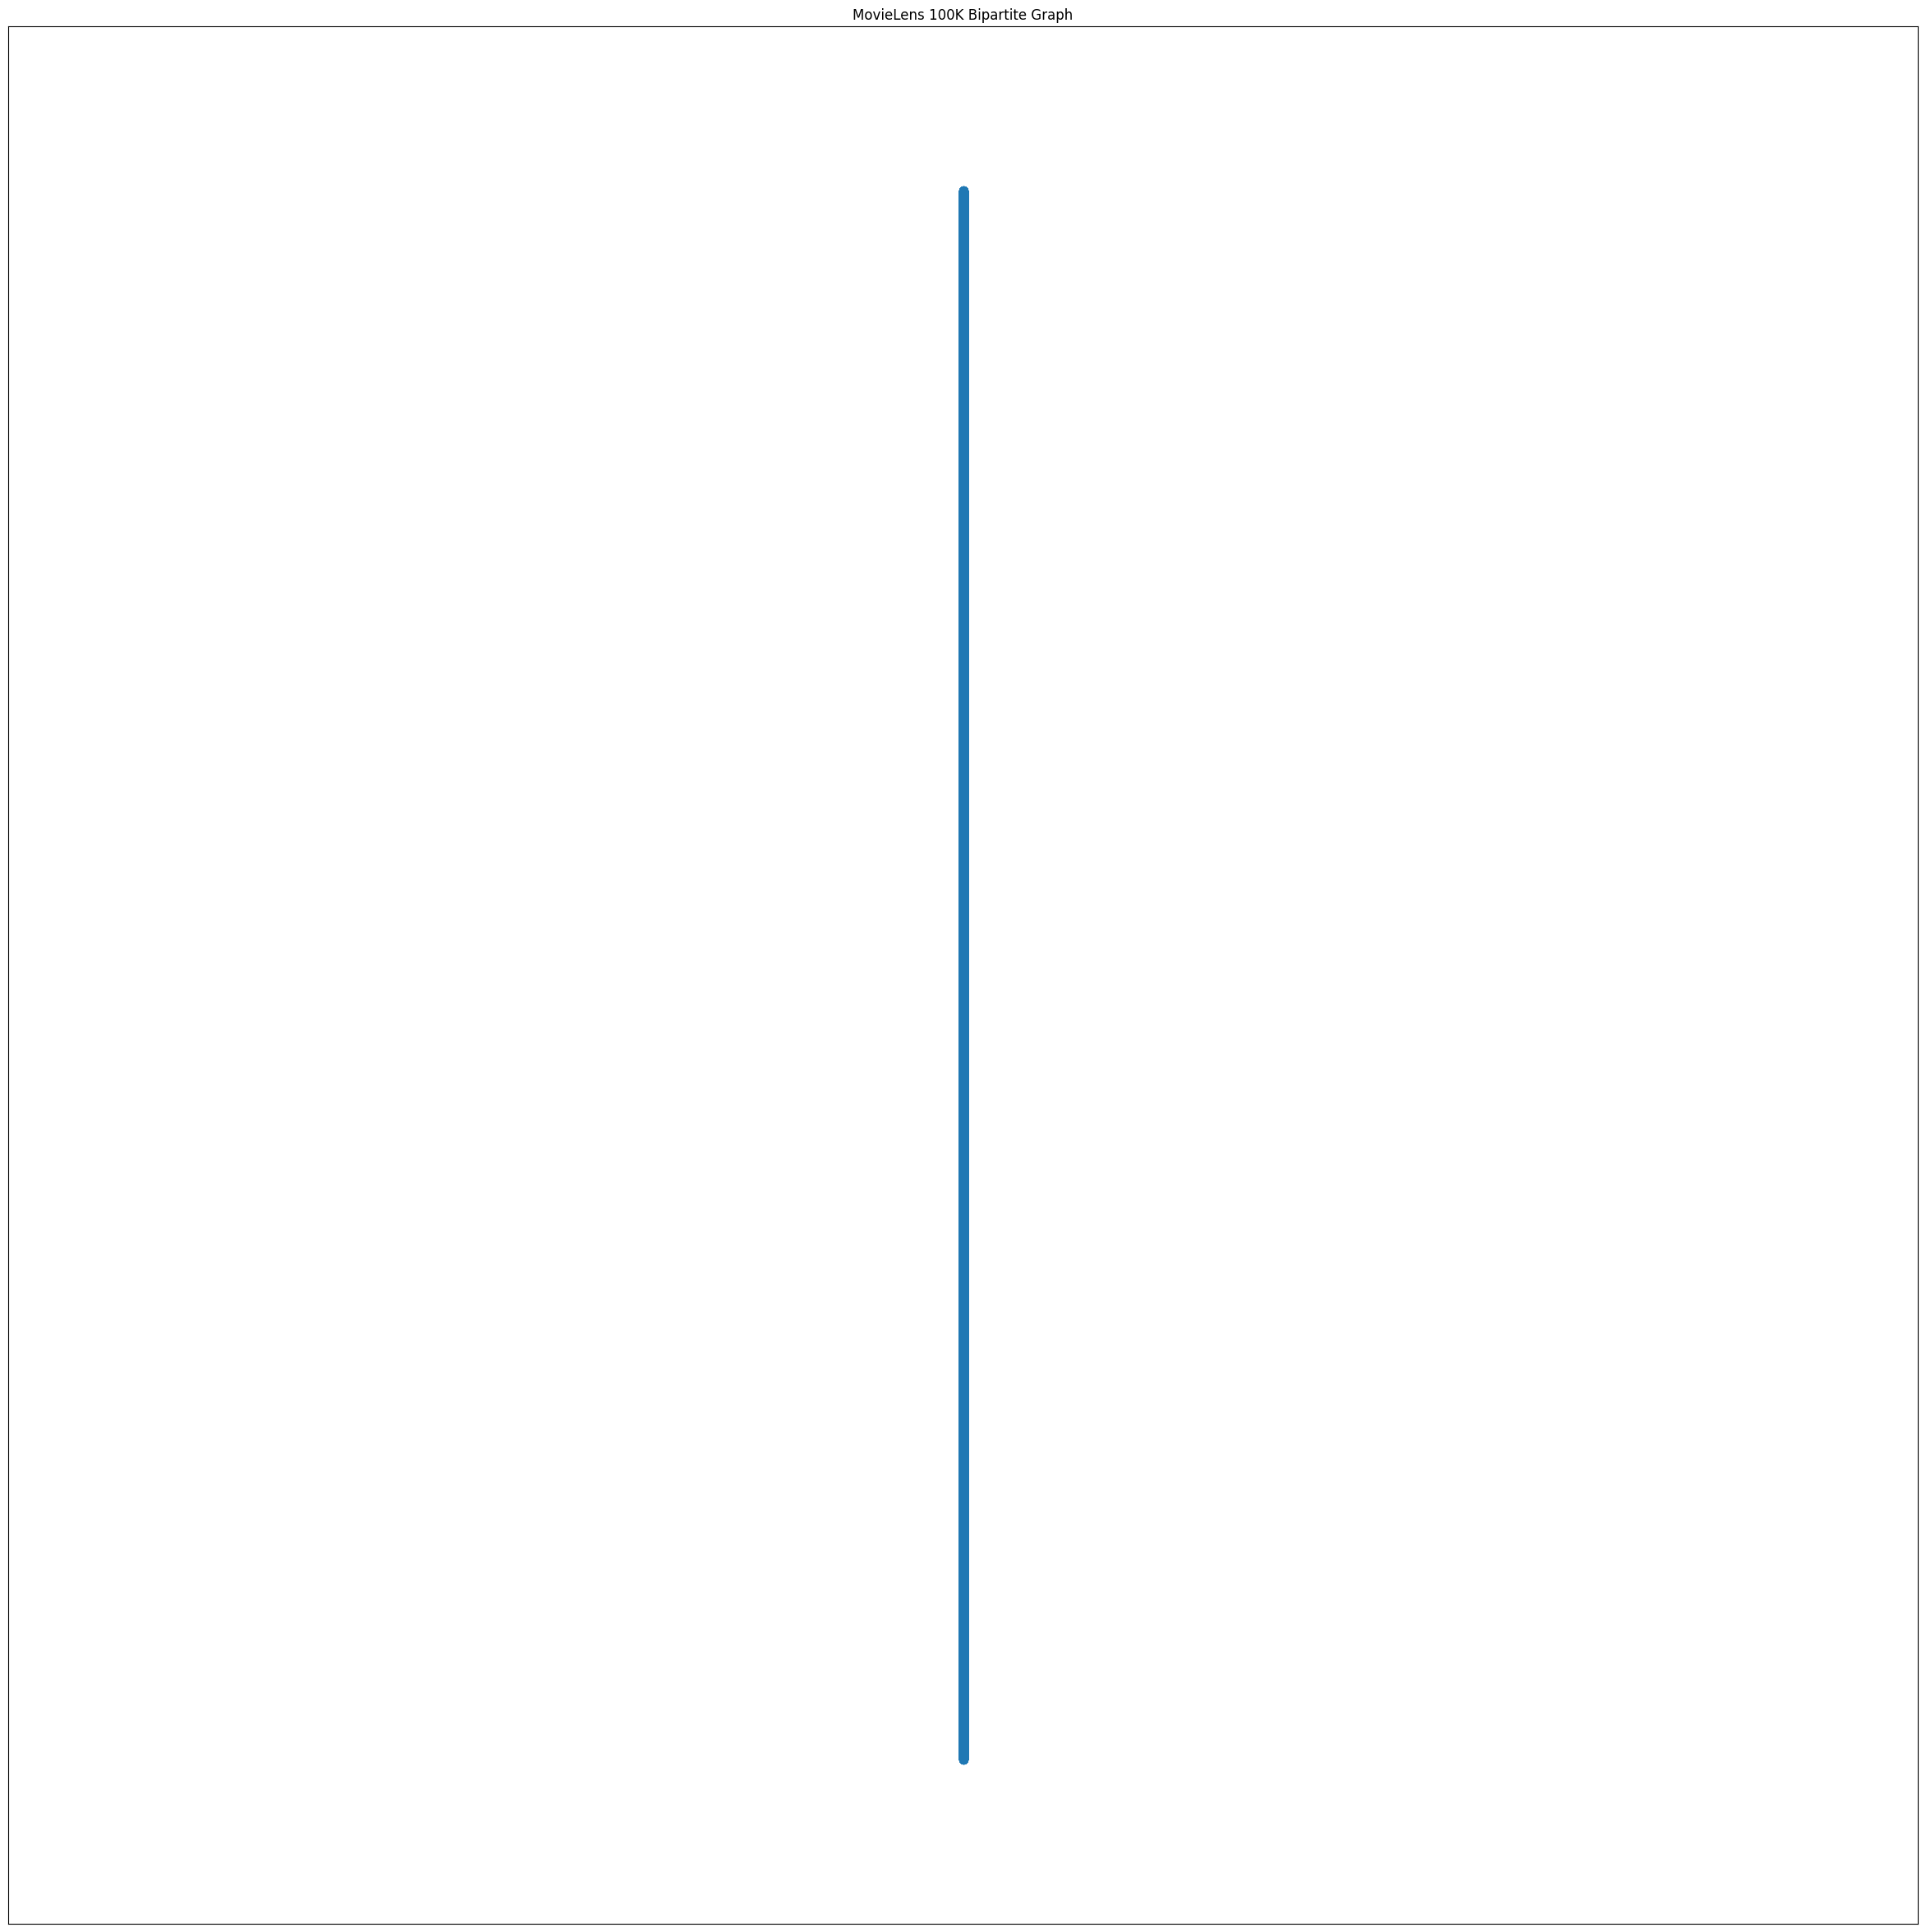

In [98]:
positions = nx.bipartite_layout(graph_nx, nodes=users_tensor.unique())

plt.figure(figsize=(30,30))
nx.draw_networkx_nodes(graph_nx, pos=positions, node_size=50)
nx.draw_networkx_edges(graph_nx, pos=positions, width=0.01, alpha=0.01)
plt.title("MovieLens 100K Bipartite Graph")
plt.show()